## Import Needed Classes

In [22]:
import statsmodels.api as sm
import sklearn.preprocessing as preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

In [24]:
def acc_report(y_test, y_pred):
    # Calculate accuracy 
    acc = accuracy_score(y_test,y_pred) * 100
    print('Accuracy is :{0}'.format(acc))

    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('\nAUC is :{0}'.format(round(roc_auc, 2)))

    # Create and print a confusion matrix 
    print('\nConfusion Matrix')
    print('----------------')
    print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

In [1]:
def plot_feature_importances(data_train, model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

## Load Data for Modeling

In [26]:
#### Load Data for Modeling
import pandas as pd

data = pd.read_csv('./data/2018_model_data.csv')

In [27]:
data.drop(columns=['Unnamed: 0'],inplace=True)

## Create features, labels, training, and test data
# Build Baseline Model Decision Tree Balanced


In [28]:
#### Create features, labels, training, and test data


In [29]:
# Split the dataset in the ratio train 80% and test 20%
X = data.drop("DELAYED", axis = 1)
y = data['DELAYED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## Train the classifier and make predictions

In [65]:

def run_dec_tree(Xtrain, ytrain, Xtest, **kwargs):
    # Build a regular tree as baseline
    tree = DecisionTreeClassifier(**kwargs )
    tree.fit(Xtrain, ytrain)
    # Make predictions for Train data
    ypred_train = tree.predict(Xtrain)
    # Make predictions for test data
    ypred_test = tree.predict(Xtest)
    return tree, ypred_train, ypred_test

In [72]:

tree_clf1, y_pred_train1, y_pred_test1 = run_dec_tree(X_train_scaled, y_train, X_test_scaled, 
                                                random_state=10, 
                                                class_weight='balanced')

## Check predictive performance

In [74]:
#x Train and y train
print(classification_report(y_train,y_pred_train1))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92   1249891
           1       0.62      0.99      0.76    304973

    accuracy                           0.88   1554864
   macro avg       0.81      0.92      0.84   1554864
weighted avg       0.92      0.88      0.89   1554864



In [75]:
#x Test and y test
print(classification_report(y_test,y_pred_test1))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79    312133
           1       0.27      0.39      0.32     76583

    accuracy                           0.68    388716
   macro avg       0.55      0.57      0.55    388716
weighted avg       0.72      0.68      0.70    388716



Observation Between the Train and the Test accuracy we have <br>
88% and F1 of 84% vs 68% and F1 of 55% so some Overfitting

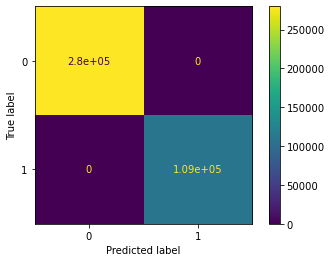

In [76]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf1, X_test_scaled, y_pred_test1, values_format='.3g')
plt.show()

In [35]:
#Observation: Accuracy 74%  Precision 84% Recall 84% F1 

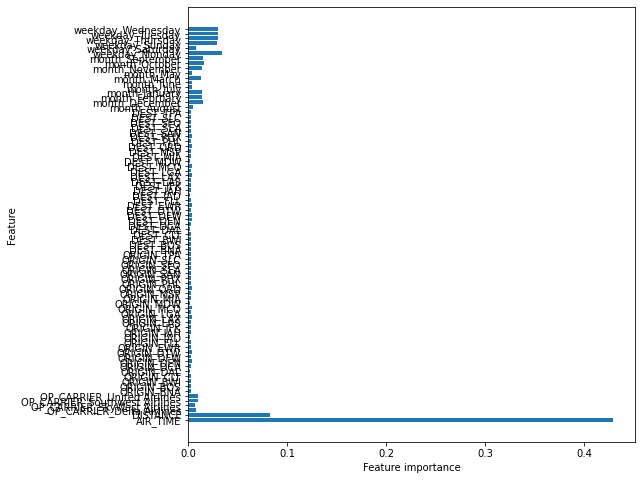

In [77]:

plot_feature_importances(X_train, tree_clf1)

In [78]:
print(tree_clf1.get_depth())

78


# Build Model Decision Tree Entropy

## Train the classifier and make predictions

In [38]:
# Build a regular tree as baseline
tree_clf2 = DecisionTreeClassifier(random_state=10,  criterion='entropy' )
tree_clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [39]:
# Make predictions for test data
y_pred2 = tree_clf2.predict(X_test)

## Check predictive performance

In [40]:
#Check predictive performance
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85    312133
           1       0.33      0.25      0.29     76583

    accuracy                           0.75    388716
   macro avg       0.58      0.56      0.57    388716
weighted avg       0.73      0.75      0.74    388716



In [41]:
acc_report(y_test, y_pred1)

Accuracy is :67.57324113234341

AUC is :0.57

Confusion Matrix
----------------
Predicted       0       1     All
True                             
0          233031   79102  312133
1           46946   29637   76583
All        279977  108739  388716


In [42]:
#Observation: Accuracy 74%  Precision 84% Recall 84% F1 

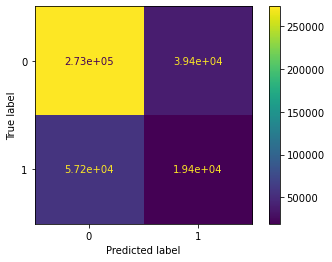

In [43]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf2, X_test, y_test, values_format='.3g')
plt.show()

In [44]:
acc_report(y_test, y_pred2)

Accuracy is :75.13480278661028

AUC is :0.56

Confusion Matrix
----------------
Predicted       0      1     All
True                            
0          272710  39423  312133
1           57232  19351   76583
All        329942  58774  388716


In [45]:
print(tree_clf2.get_depth())

77


# GridSearch for optimal params

In [79]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [40, 60, 80],
    'min_samples_split': [500, 1000],
    'min_samples_leaf': [100, 200, 300],
    'class_weight' : ['balanced']
}

gs_tree = GridSearchCV(clf, param_grid, cv=3,return_train_score=True)
gs_tree.fit(X_train_scaled, y_train)

gs_tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'min_samples_leaf': 100,
 'min_samples_split': 500}

In [81]:
gs_tree.cv_results_

{'mean_fit_time': array([28.3007164 , 29.70353206, 27.95555512, 27.2215484 , 26.49144801,
        26.98746665, 28.89768783, 27.30031737, 29.40764769, 27.78503307,
        26.34683426, 26.1204505 , 28.50641274, 28.36810644, 26.83120664,
        27.08888602, 26.57192302, 25.77604079, 29.54361049, 28.84351214,
        28.78633157, 26.78665924, 27.91264574, 25.92663773, 29.00807285,
        29.32256532, 27.11579092, 27.59154073, 28.45553986, 26.78136341,
        27.8129313 , 28.19357236, 28.62178644, 28.88975843, 28.18872054,
        27.00894229]),
 'std_fit_time': array([0.40375629, 3.56096494, 0.46957772, 0.99057613, 0.61588948,
        1.03696991, 1.26348029, 0.46417584, 2.28878258, 0.86684555,
        0.36563828, 0.62182048, 0.400835  , 1.44996012, 0.25105482,
        0.3131901 , 0.67413882, 0.42560671, 1.16883616, 1.01229766,
        2.51919021, 0.3964824 , 1.5684536 , 0.49904243, 1.50283039,
        1.64619382, 0.26824359, 0.77127807, 2.52364229, 0.39873601,
        0.47824711, 1.147

In [80]:
# Mean training score
dt_gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = gs_tree.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")

Mean Training Score: 62.93%
Mean Test Score: 63.13%


Observation 
optimal {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'min_samples_leaf': 100,
 'min_samples_split': 500}
Mean Training Score: 62.93%
Mean Test Score: 63.13%

# GridSearch 2 for optimal params

In [83]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini'],
    'max_depth': [30, 40, 45],
    'min_samples_split': [100 ,200, 500, 600],
    'min_samples_leaf': [50, 100, 125],
    'class_weight' : ['balanced']
}

gs_tree2 = GridSearchCV(clf, param_grid, cv=3,return_train_score=True)
gs_tree2.fit(X_train_scaled, y_train)

gs_tree2.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 50,
 'min_samples_split': 200}

In [84]:
gs_tree2.cv_results_

{'mean_fit_time': array([38.52468697, 35.04388968, 35.39275678, 34.49780083, 34.30702202,
        34.60995022, 36.64594102, 33.86681239, 35.18403061, 33.95157385,
        34.0512557 , 37.42392699, 35.45717557, 35.98871883, 42.48442841,
        49.67643277, 43.37029266, 43.79688263, 41.48250977, 46.89877335,
        42.03583678, 39.84167671, 39.36175346, 42.05481116, 38.5049332 ,
        41.36010305, 40.10469254, 40.82431555, 40.91318297, 39.69527324,
        37.57667232, 38.00493399, 38.99534885, 37.28380203, 38.10281054,
        37.95258268]),
 'std_fit_time': array([0.77206657, 0.18677227, 1.18221453, 0.90252563, 0.0795965 ,
        0.80086647, 2.15624903, 1.16510963, 2.07724112, 0.07562155,
        0.35012786, 3.33143182, 0.31970164, 0.25421246, 3.91878777,
        4.15222185, 2.80208903, 1.99290337, 1.58147868, 2.78384809,
        2.06534361, 1.79752182, 1.38369503, 1.8759815 , 0.66790721,
        3.91591661, 2.05233509, 1.21278464, 0.91533964, 0.73966471,
        1.07069813, 1.063

In [85]:
# Mean training score
dt_gs_training_score = np.mean(gs_tree2.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = gs_tree2.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")

Mean Training Score: 64.44%
Mean Test Score: 19.70%


In [ ]:
Observation {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 50,
 'min_samples_split': 200}
Mean Training Score: 64.44%
Mean Test Score: 19.70%

# GridSearch 2 for optimal params

In [83]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini'],
    'max_depth': [30, 40, 45],
    'min_samples_split': [100 ,200, 500, 600],
    'min_samples_leaf': [50, 100, 125],
    'class_weight' : ['balanced']
}

gs_tree2 = GridSearchCV(clf, param_grid, cv=3,return_train_score=True)
gs_tree2.fit(X_train_scaled, y_train)

gs_tree2.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 50,
 'min_samples_split': 200}

In [84]:
gs_tree2.cv_results_

{'mean_fit_time': array([38.52468697, 35.04388968, 35.39275678, 34.49780083, 34.30702202,
        34.60995022, 36.64594102, 33.86681239, 35.18403061, 33.95157385,
        34.0512557 , 37.42392699, 35.45717557, 35.98871883, 42.48442841,
        49.67643277, 43.37029266, 43.79688263, 41.48250977, 46.89877335,
        42.03583678, 39.84167671, 39.36175346, 42.05481116, 38.5049332 ,
        41.36010305, 40.10469254, 40.82431555, 40.91318297, 39.69527324,
        37.57667232, 38.00493399, 38.99534885, 37.28380203, 38.10281054,
        37.95258268]),
 'std_fit_time': array([0.77206657, 0.18677227, 1.18221453, 0.90252563, 0.0795965 ,
        0.80086647, 2.15624903, 1.16510963, 2.07724112, 0.07562155,
        0.35012786, 3.33143182, 0.31970164, 0.25421246, 3.91878777,
        4.15222185, 2.80208903, 1.99290337, 1.58147868, 2.78384809,
        2.06534361, 1.79752182, 1.38369503, 1.8759815 , 0.66790721,
        3.91591661, 2.05233509, 1.21278464, 0.91533964, 0.73966471,
        1.07069813, 1.063

In [85]:
# Mean training score
dt_gs_training_score = np.mean(gs_tree2.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = gs_tree2.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")

Mean Training Score: 64.44%
Mean Test Score: 19.70%


Observation {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 50,
 'min_samples_split': 200}  
Mean Training Score: 64.44%
Mean Test Score: 19.70%

# GridSearch 3 for optimal params

In [104]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini'],
    'max_depth': [10],
    'min_samples_leaf': [16, 17],
    'min_samples_split': [50],
    'class_weight' : ['balanced']
}

gs_tree3 = GridSearchCV(clf, param_grid, cv=3,return_train_score=True)
gs_tree3.fit(X_train_scaled, y_train)

gs_tree3.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 16,
 'min_samples_split': 50}

In [ ]:
Observation  FINAL{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 16,
 'min_samples_split': 50}

In [ ]:
Observation{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 16,
 'min_samples_split': 50}

Observation {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 14,
 'min_samples_split': 50}

In [ ]:
Observation {'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 15,
 'min_samples_split': 50}

In [105]:
gs_tree3.cv_results_

{'mean_fit_time': array([21.55102173, 20.06830192]),
 'std_fit_time': array([0.39031091, 0.08596341]),
 'mean_score_time': array([0.18549625, 0.16555945]),
 'std_score_time': array([0.00243742, 0.00567589]),
 'param_class_weight': masked_array(data=['balanced', 'balanced'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_criterion': masked_array(data=['gini', 'gini'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[16, 17],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[50, 50],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'class_weight': 'balanced',
   'criterion': 'gini',
   'max_de

In [106]:
# Mean training score
dt_gs_training_score = np.mean(gs_tree3.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = gs_tree3.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")

Mean Training Score: 66.99%
Mean Test Score: 63.11%


# Run Model with Optimal Params



Grid Search identified these params as optimal<br>
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}

Run Time 2 hrs 56 mins <br>
secondrun
{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}
 Mean Training Score: 64.48%
Mean Test Score: 74.05%

## Train the classifier and make predictions

In [107]:
# Build a regular tree as baseline
tree_clf4, y_pred_train4, y_pred_test4 = run_dec_tree(X_train_scaled, y_train, X_test_scaled, 
                                                random_state=10,  criterion='gini',
                                   class_weight='balanced',
                                   max_depth= 10,
                                   min_samples_leaf =16,
                                   min_samples_split = 50)

## Check predictive performance

In [108]:
#Check predictive performance Train
print(classification_report(y_train,y_pred_train4))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79   1249891
           1       0.27      0.39      0.32    304973

    accuracy                           0.68   1554864
   macro avg       0.55      0.57      0.55   1554864
weighted avg       0.72      0.68      0.70   1554864



In [109]:
#Check predictive performance Test
print(classification_report(y_test,y_pred_test4))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79    312133
           1       0.27      0.39      0.32     76583

    accuracy                           0.68    388716
   macro avg       0.55      0.57      0.55    388716
weighted avg       0.72      0.68      0.70    388716



In [110]:
acc_report(y_test, y_pred_test4)

Accuracy is :67.57324113234341

AUC is :0.57

Confusion Matrix
----------------
Predicted       0       1     All
True                             
0          233031   79102  312133
1           46946   29637   76583
All        279977  108739  388716


In [ ]:
#Observation: Accuracy 81%  Precision 81% Recall 99% F1 89

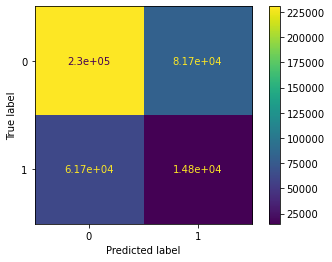

In [111]:
# Alternative confusion matrix
plot_confusion_matrix(tree_clf4, X_test, y_test, values_format='.3g')
plt.show()

In [99]:
from sklearn import tree


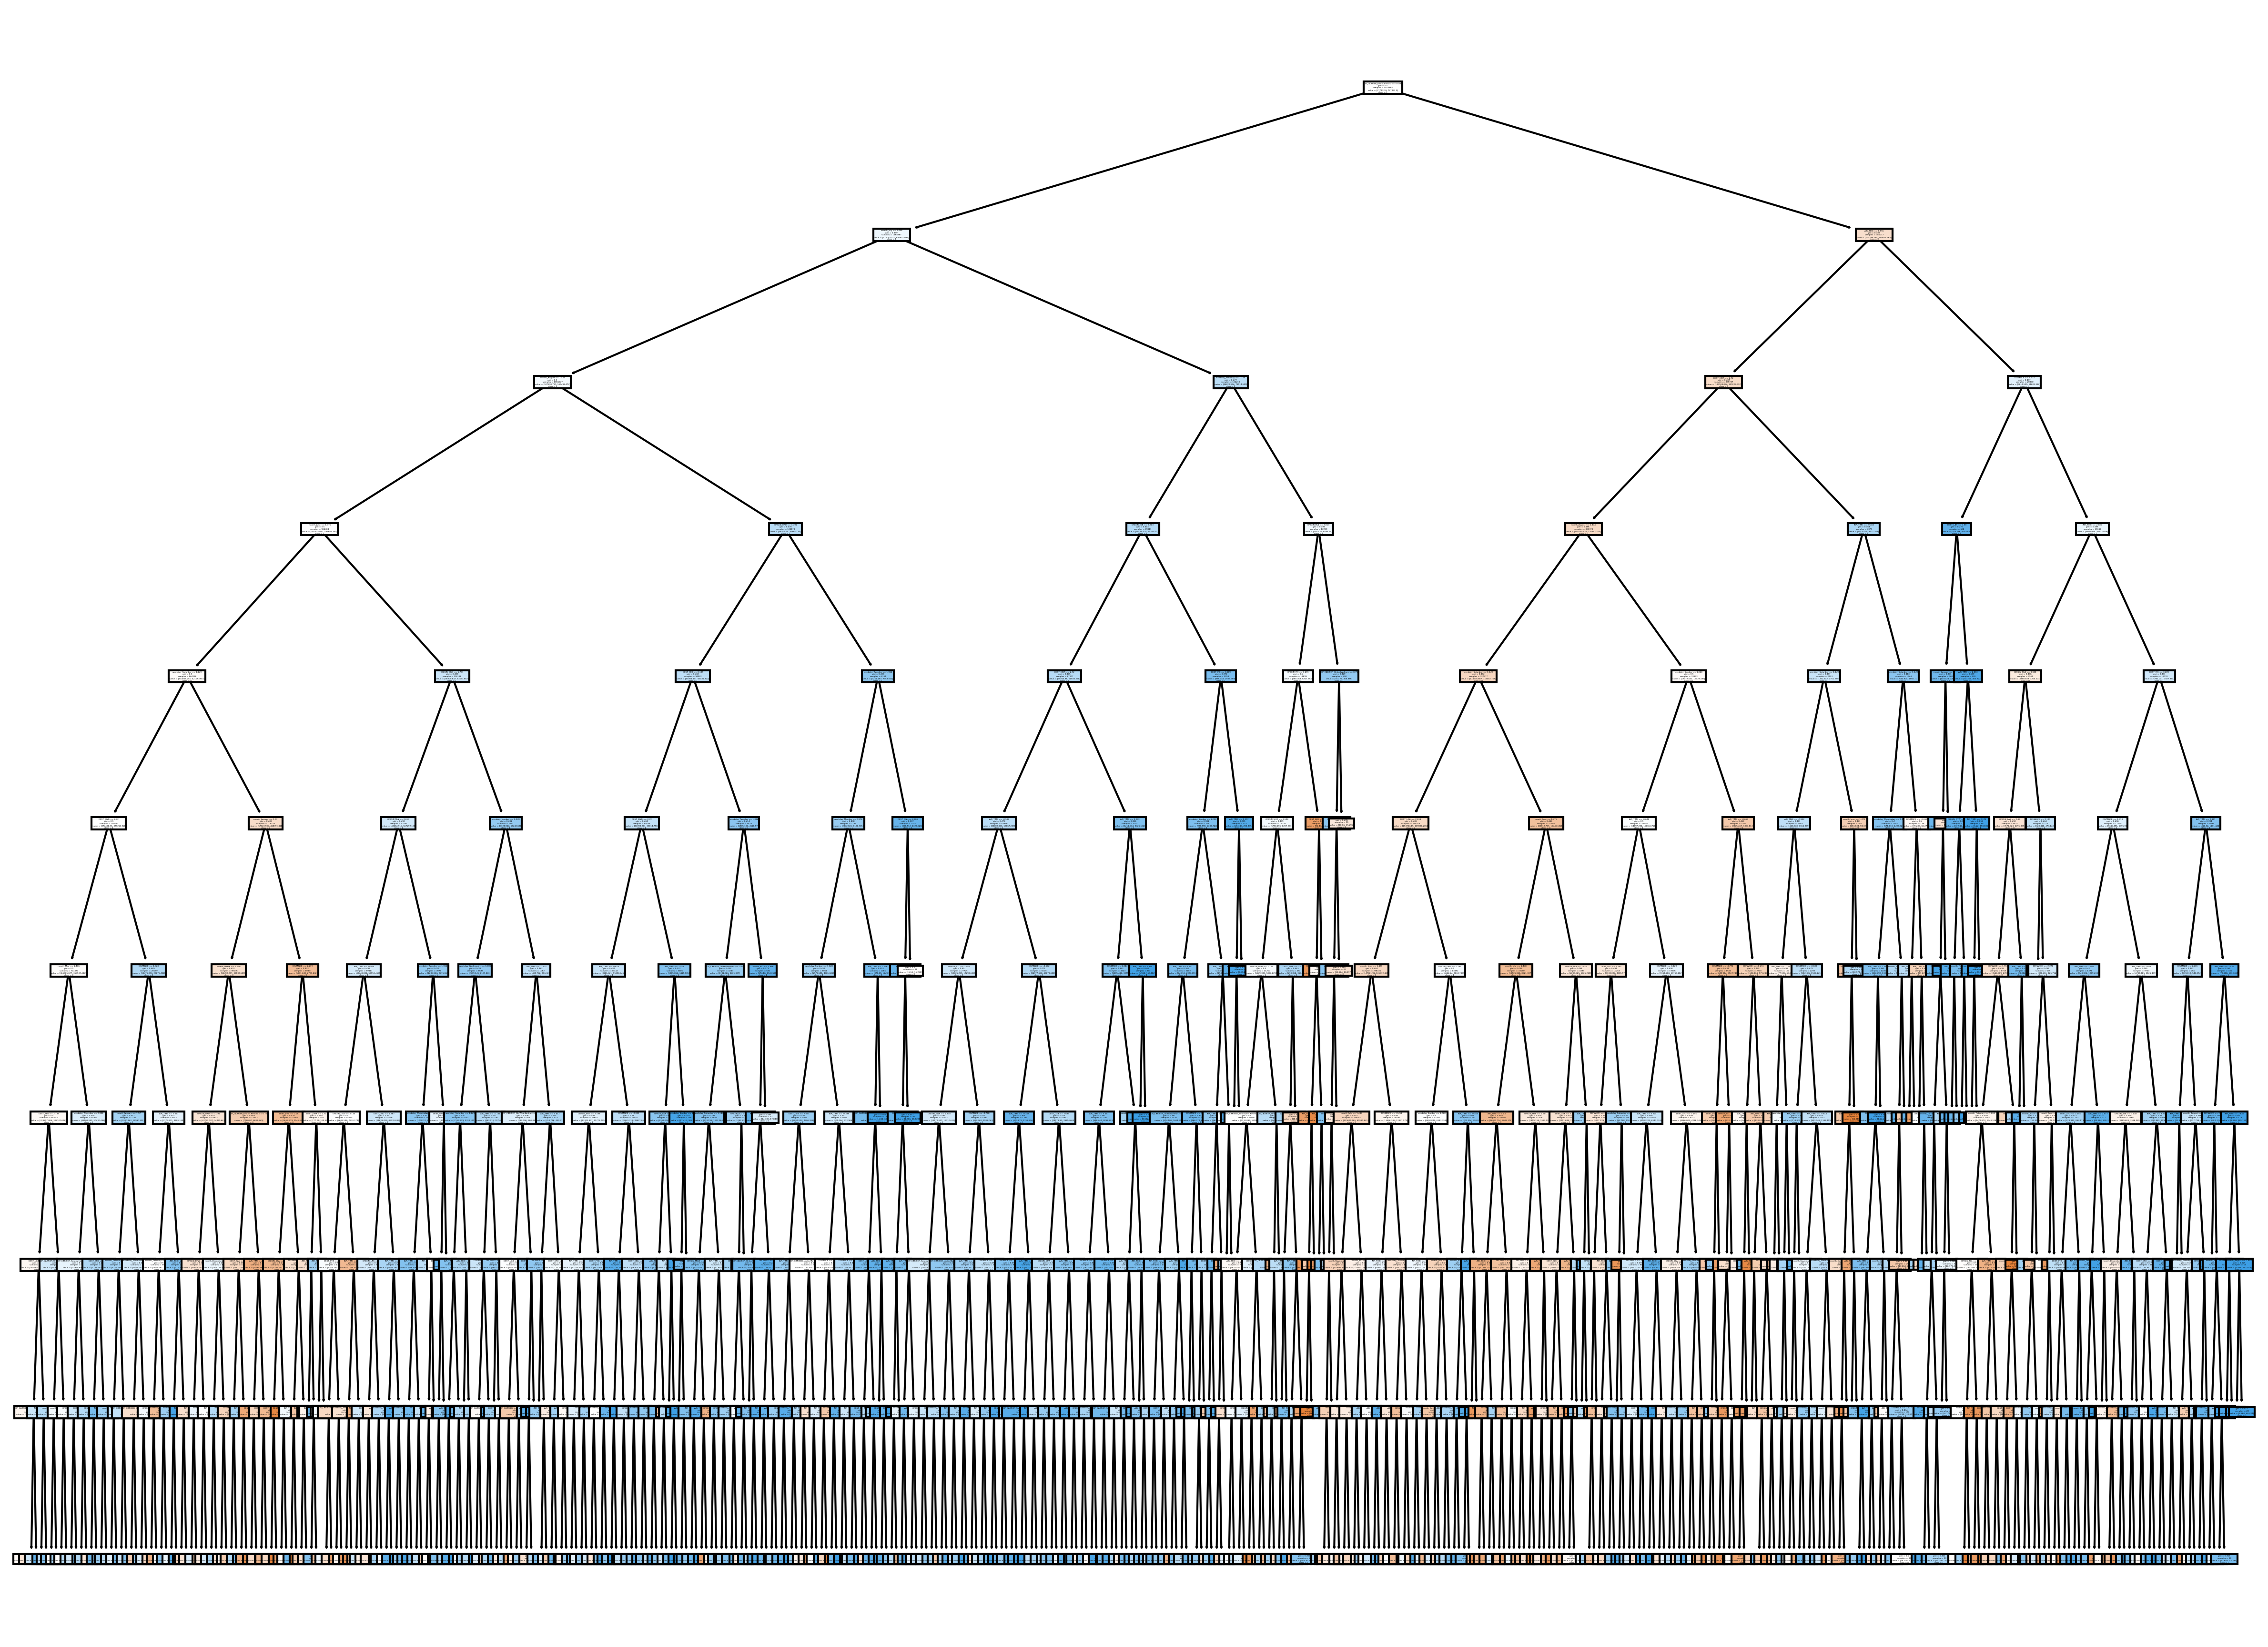

In [112]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (20,15), dpi=300)
tree.plot_tree(tree_clf4,
               feature_names = X.columns,
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()